In [78]:
# Load packages
using Parameters
using QuantEcon
using Plots
using Format
using Interpolations
using Optim

## Problem 1

Part a

In [79]:
# Define the utility function
function u(c, l, p)
    @unpack β, σ, ν, ϕ = p
    return (c^(1-σ))/(1 - σ) - ϕ * (l^(1+1/ν)/(1 + 1/ν))
end

function update_bellman!(p, V, policy, kgrid, V0, max_idxs)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, n)  # Adjusting the number of choices for labor supply
    
    vmax = -Inf
    max_idx = 0
    
    for i in 1:n
        k = kgrid[i]

        ki′ = 0
        li′ = 0
        ci′ = 0
        
        for j in 1:n
            k′ = kgrid[j]
            for b in 1:n  # Using num_l_values for the loop
                l = l_values[b]
                c′ = A * k^α * l^(1-α) + (1-δ) * k - k′
                if c′ >= 0
                    v = u(c′, l, p) + β * V0[j]
                    if v >= vmax
                        vmax = v
                        ki′ = kgrid[j]
                        li′ = l_values[b]
                        ci′ = c′
                        max_idx = i  # Store the index where vmax occurs
                    end
                end
            end
        end

        V[i] = vmax 
        policy[i] = (ki′, li′, ci′)  
    end
    
    # Store the index of vmax
    push!(max_idxs, max_idx)
end

# Implement the VFI algorithm
function solve_vfi(p, kgrid; tol = 1e-6, max_iter = 1000)
    V0 = zeros(length(kgrid))
    V = similar(V0)
    policy = Array{Tuple{Float64, Float64, Float64}, 1}(undef, length(kgrid))
    max_idxs = []  # Array to store the index of vmax
    
    for iter in 1:max_iter
        update_bellman!(p, V, policy, kgrid, V0, max_idxs)
        error = maximum(abs.(V .- V0))
        if error < tol
            println("Converged after $iter iterations.")
            return V, policy, max_idxs
        end
        copy!(V0, V)
    end
    
    error("Did not converge after $max_iter iterations.")
end

# Parameters
p = (
    β = 0.95,    # Discount Rate
    δ = 0.05,    # Depreciation of capital
    σ = 2.0,     # Uncertainty aversion
    ν = 2.0,     # Risk aversion
    α = 1/3,     # Returns to scale
    A = 1.0,     # Productivity
    ϕ = 1.0     # Disutility from labor

)



(β = 0.95, δ = 0.05, σ = 2.0, ν = 2.0, α = 0.3333333333333333, A = 1.0, ϕ = 1.0)

Converged after 331 iterations.
Converged after 331 iterations.
Converged after 331 iterations.
Converged after 331 iterations.


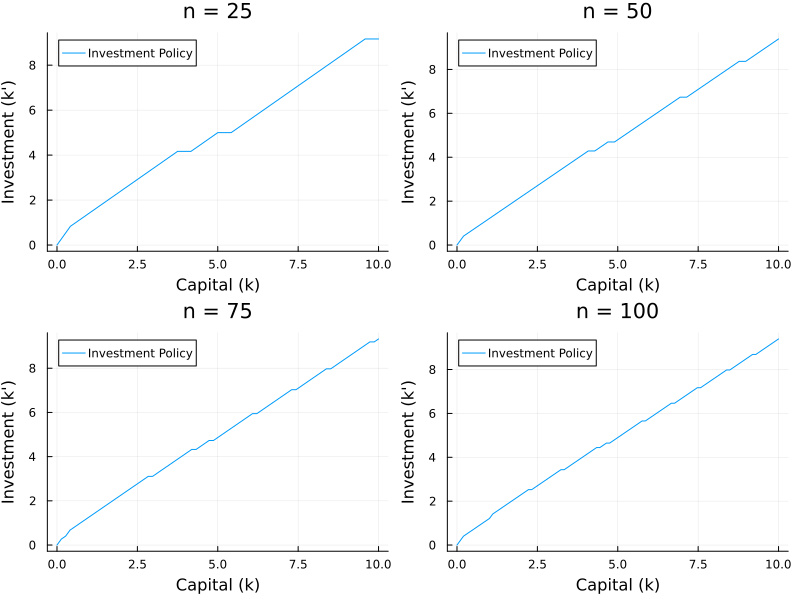

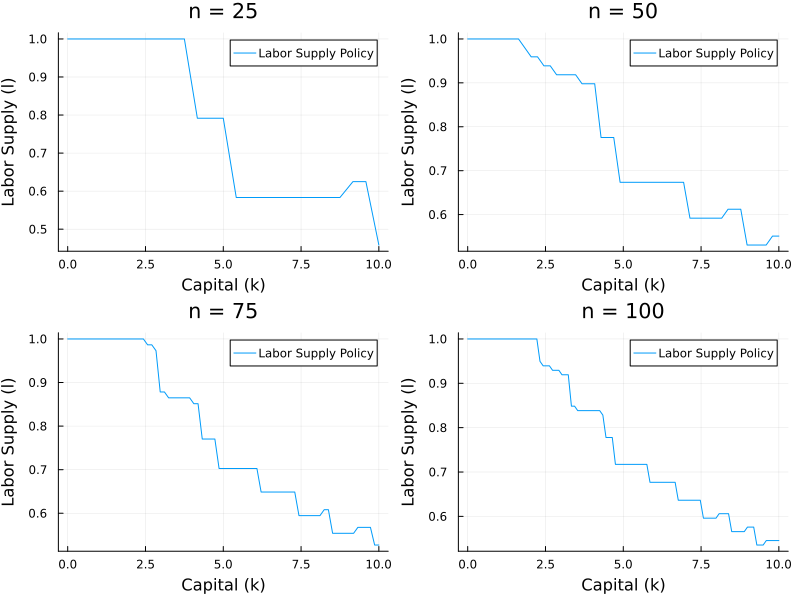

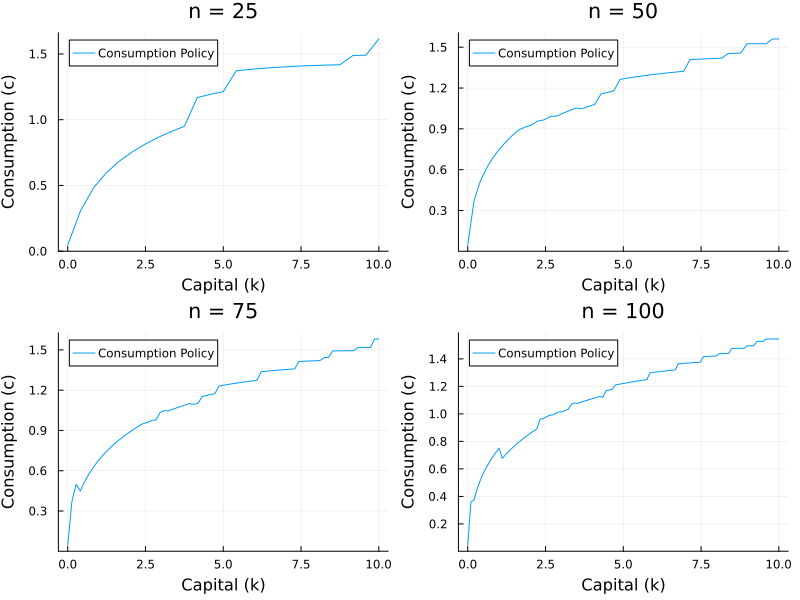

In [80]:
n_values = [25, 50, 75, 100]
plot_titles = ["n = 25", "n = 50", "n = 75", "n = 100"]
plots_investment = []
plots_labour = []
plots_consumption = []

for (i, n) in enumerate(n_values)
    # Define the grid for capital
    kgrid = LinRange(1e-4, 10, n)
    
    # Solve the model
    V, policy, max_idxs = solve_vfi(p, kgrid)
    
    # Extract policy functions
    ki_policy = [p[1] for p in policy]
    li_policy = [p[2] for p in policy]
    ci_policy = [p[3] for p in policy]

    # Get x and y coordinates of maximum values
    max_x_values = kgrid[max_idxs[1]]
    max_y_values = V[max_idxs[1]]
    
    # Plot policy functions with markers at maxima
    p1 = plot(kgrid, ki_policy, xlabel="Capital (k)", ylabel="Investment (k')", label="Investment Policy", title=plot_titles[i])
    push!(plots_investment, p1)
    
    p2 = plot(kgrid, li_policy, xlabel="Capital (k)", ylabel="Labor Supply (l)", label="Labor Supply Policy", title=plot_titles[i])
    push!(plots_labour, p2)
    
    p3 = plot(kgrid, ci_policy, xlabel="Capital (k)", ylabel="Consumption (c)", label="Consumption Policy", title=plot_titles[i])
    push!(plots_consumption, p3)

end

display(plot(plots_investment..., layout=(2, 2), size=(800, 600)))
display(plot(plots_labour..., layout=(2, 2), size=(800, 600)))
display(plot(plots_consumption..., layout=(2, 2), size=(800, 600)))


We can see from the graphs that as the capital rises the investment policy rises, this is what we would expect as because when capital rises with the same depreciation rate the cost of replacing the capital rises. On the next graph we see as capital rises, labour supply decreases. This is what we would expect as when they have more capital there is less incentive to make money from working. What is interesting is that up to capital of 2.5 the labour supply does not decrease. This could suggest that they potentially have a target wage, and that even as capital is increasing they are still working the same however after capital is greater than 2.5, as capital increases labour supply decreases. Additionally, from the final graph we capital is directly linked to consumption and as capital increases so does consumption. Interestingly on this graph, when capital is 0 consumption is almost 0 as well, we believe that this comes from the form of the Cobb-Douglas production function, that when capital is very low so is production. So when capital initially starts increasing consumption does so exponentially then consumption grows slower as capital increases.

We can see on the graphs that as we increase n the lines have more small bumps in them but are in general smoother and more accurate to what the real lines would be.

Part b

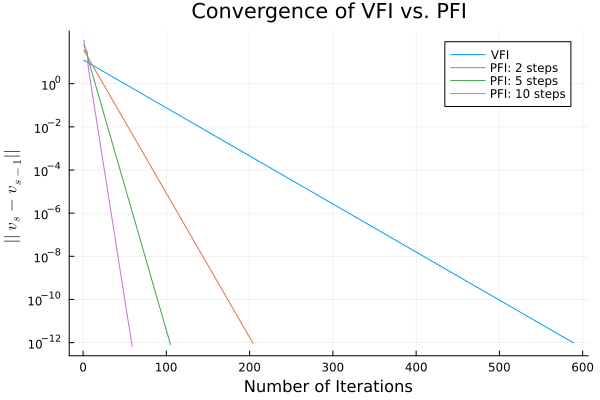

In [113]:
# Parameters
p = (
    β = 0.95,    # Discount Rate
    δ = 0.05,    # Depreciation of capital
    σ = 2.0,     # Uncertainty aversion
    ν = 2.0,     # Risk aversion
    α = 1/3,     # Returns to scale
    A = 1.0,     # Productivity
    ϕ = 1.0     # Disutility from labor

)


# Define the utility function
function u(c, l, p)
    @unpack β, σ, ν, ϕ = p
    result = (c^(1-σ))/(1 - σ) - ϕ * (l^(1+1/ν)/(1 + 1/ν)) 
    return result > 0 ? log(result) : -Inf
end

function update_bellman!(p, V, policy, kgrid, V0)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, n)  # Adjusting the number of choices for labor supply
    
    l_list = []
    c_list = []
    
    for i in 1:n
        k = kgrid[i]
        vmax = -Inf

        ki′ = 0
        li′ = 0
        ci′ = 0
        
        for j in 1:n
            k′ = kgrid[j]
            for b in 1:n  # Using num_l_values for the loop
                l = l_values[b]
                c = A * k^α * l^(1-α) + (1-δ) * k - k′
                v = u(c, l, p) + β * V0[j]
                if v >= vmax
                    vmax = v
                    ki′ = j
                    li′ = b
                    ci′ = c
                    
                end
            end
        end

        V[i] = vmax 
        policy[i] = ki′  
        push!(l_list, l_values[li′])
        push!(c_list, ci′)
    end

end


function policy_step!(p, V, policy, kgrid, V0)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, n)  # Adjusting the number of choices for labor supply
    
    for i in 1:n
        vmax = -Inf
        k = kgrid[i]
        k′ = kgrid[policy[i]]
        l′ = 0
        c′ = 0
        
        for j in 1:n
            l = l_values[j]
            c = A * k^α * l^(1-α) + (1-δ) * k - k′
            v = u(c, l, p) + β * V0[policy[i]]
            
            if v >= vmax
                vmax = v
                l′ = l
                c′ = c
            end
        end
        
        V[i] = u(c′, l′, p) + β * V0[policy[i]]
    end
end



function solve_pfi!(p, kgrid, V0; tol = 1e-12, policy_steps = 0, max_iter = 1000)

    V0      = copy(V0)
    V       = similar(V0)
    Vs      = similar(V0)

    policy = zeros(Int, size(V0))
    errors  = Float64[]  
    iter    = 0
    
    while true
        # Update our value function
        iter += 1
        # V0 ~ V_{s-1}(k)
        # V ~ V_{s}^0(k)
        update_bellman!(p, Vs, policy, kgrid, V0)  
        V .= Vs # this is redundant, but makes this code work if policy_steps = 0

        # Iterate on the policy rule 
        for i in 1:policy_steps
            # Vs ~ V_s^{j-1}
            # V  ~ V_s^j
            policy_step!(p, V, policy, kgrid, Vs)
            Vs .= V
        end
        

        # calculate and save the errors
        ϵ = maximum(abs.(V - V0))
        push!(errors, ϵ)
       
        # stop if we've converged
        ϵ < tol         && break
        iter > max_iter  && break 
        V0 .= V
    end

    return (; V, policy, iter, errors)
end

n = 100

solution_vfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n))
@unpack errors = solution_vfi
plt = plot(1:length(errors), errors, yscale = :log10, 
    title  = "Convergence of VFI vs. PFI",
    label  = "VFI",
    xlabel = "Number of Iterations",
    ylabel = raw"$||v_s - v_{s-1}||$",
    yticks = 10.0.^(0:-2:-12)
)

for k in (2, 5, 10)
    solution_pfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n), policy_steps = k)
    @unpack errors = solution_pfi
    plot!(1:length(errors), errors,
        label = "PFI: $k steps" 
    )
end

display(plt)


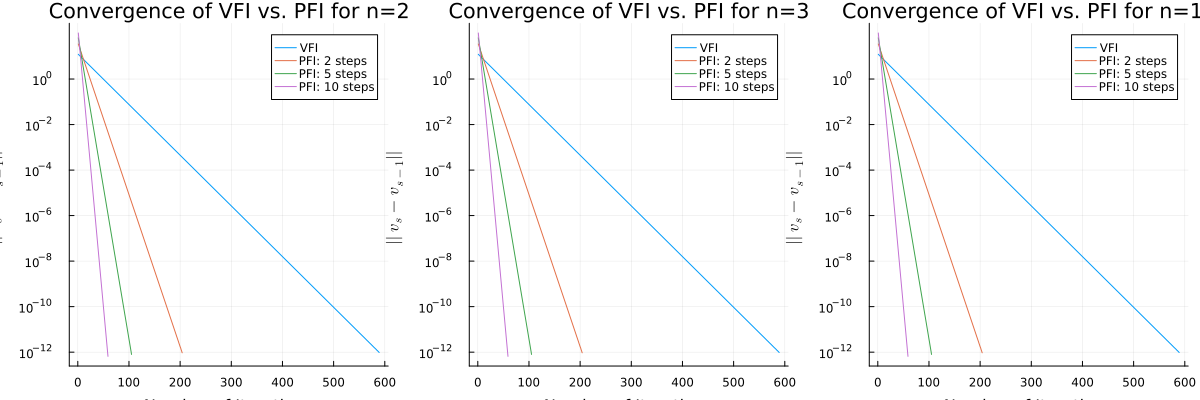

In [114]:
n_values = [2, 3, 15]

plots = []

for n in n_values
    plot()
    solution_vfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n))
    @unpack errors = solution_vfi
    plt = plot(1:length(errors), errors, yscale=:log10, 
                title="Convergence of VFI vs. PFI for n=$n",
                label="VFI",
                xlabel="Number of Iterations",
                ylabel=raw"$||v_s - v_{s-1}||$",
                yticks=10.0 .^(0:-2:-12)
    )
    
    for k in (2, 5, 10)
        solution_pfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n), policy_steps=k)
        @unpack errors = solution_pfi
        plot!(1:length(errors), errors,
              label="PFI: $k steps"
        )
    end
    push!(plots, plt)
end

plt = plot(plots..., size=(1200, 400), layout=(1, length(n_values)), legend=:topright)
display(plt)


We see that by plotting the log error, that as n increases the gradients of the lines get closer to the convergence of the value function iteration. After looking at different values of the steps, the smaller is the step the less number of iterations it takes to converge. We would suggest that if the value of the steps was large enough we would get the same line as the value function iteration. We think the gradient of the lines show the speed of log convergence. 
After testing out multiple values of n, it appears to get an accurate approximation of the convergence we only need n=2. Which is the smallest n that is possible as you can't have n as 1 as it has to be the start and end point, so n=1 would not make a line. 

Part c

By using the hint and what was discussed in tutorials we reparametrise the problem as:

$$\max_{c,k',l} u(c,l) + \beta v(k') \newline s.t \newline c = \phi \cdot (F(k,l)+(1-\delta)k) \newline k' = (1-\phi) \cdot (F(k,l)+(1-\delta)k)$$ 
This makes the optimisation significanly easier as we now have box constraints where $l \in [0,1]$ and $\phi \in [0,1]$.

In [84]:
using Optim
# Parameters
p = (
    β = 0.95,    # Discount Rate
    δ = 0.05,    # Depreciation of capital
    σ = 2.0,     # Uncertainty aversion
    ν = 2.0,     # Risk aversion
    α = 1/3,     # Returns to scale
    A = 1.0,     # Productivity
    ϕ = 1.0     # Disutility from labor

)
function u(c, l, p)
    @unpack β, σ, ν, ϕ = p
    return (c^(1-σ))/(1 - σ) - ϕ * (l^(1+1/ν)/(1 + 1/ν))
end

function F(k, l)
    α=1/3
    A = 1
    return A * k^α * l^(1-α)
end
function update_bellman_cubic!(p, V, policy, kgrid, V0, max_idxs)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, n)  # Adjusting the number of choices for labor supply
    
    # Its either calculate the spline before, or calculate it depending on what previous term 
    spl = CubicSplineInterpolation(kgrid, V0, extrapolation_bc=Line())

    for i in 1:n
        k = kgrid[i]
        # Or spline calculation here
        #spl = CubicSplineInterpolation(kgrid, V, extrapolation_bc=Line())
        function obj_fun!(x)
            l = x[1]
            phi = x[2]
            c = phi*(A * k^α * l^(1-α) + (1-δ) * k)
            kp = (1-phi)*(A * k^α * l^(1-α) + (1-δ) * k)
            if c <= 0 || kp <= 0
                return -Inf
            end
            obj = u(c, l, p) + β * spl(kp)
            return -obj
        end
        
        # Initial guess for labor supply and phi
        x0 = [0.2, 0.5]  # Adjust initial guess as needed
        
        # Bounds for labor supply and phi
        lower = [1e-3, 1e-3]
        upper = [1.0-1e-3, 1.0-1e-3]
        
        # Optimization
        res = optimize(obj_fun!, lower, upper, x0, Fminbox())
        
        l_opt, phi_opt = Optim.minimizer(res)
        c_opt = phi_opt * (A * k^α * l_opt^(1-α) + (1-δ) * k)
        kp_opt = (1-phi_opt) * (A * k^α * l_opt^(1-α) + (1-δ) * k)
        V[i] = -obj_fun!([l_opt, phi_opt])  # Negative because we maximized negative utility
        policy[i] = (kp_opt, l_opt, c_opt)
    end
end

# Define parameters
p = (β = 0.95, δ = 0.05, σ = 2.0, ν = 2.0, α = 1/3, A = 1.0, ϕ =1.0)

# Define kgrid

kgrid = LinRange(1e-4, 10, 10)
n = length(kgrid)
# Change V0 so its saved from the 1a case to use for the interpolation so its more accurate
V0 = zeros(length(kgrid))
V = similar(V0)
max_idxs = []
policy = Array{Tuple{Float64, Float64, Float64}, 1}(undef, n)

update_bellman_cubic!(p, V, policy, kgrid, V0, max_idxs)
# Call the solver function

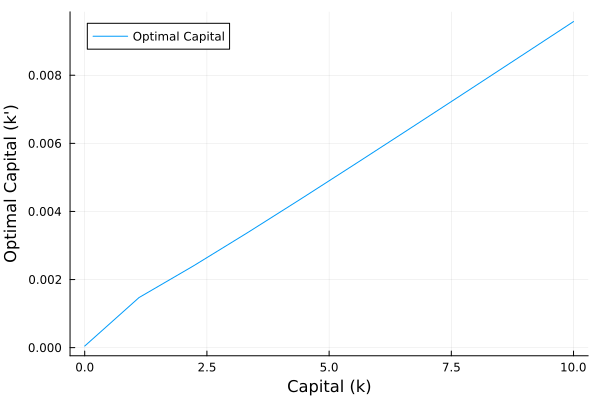

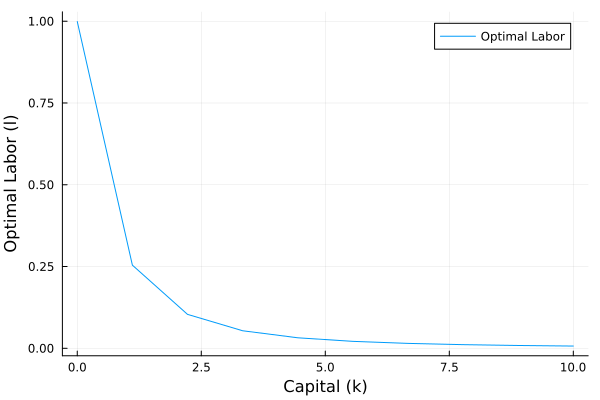

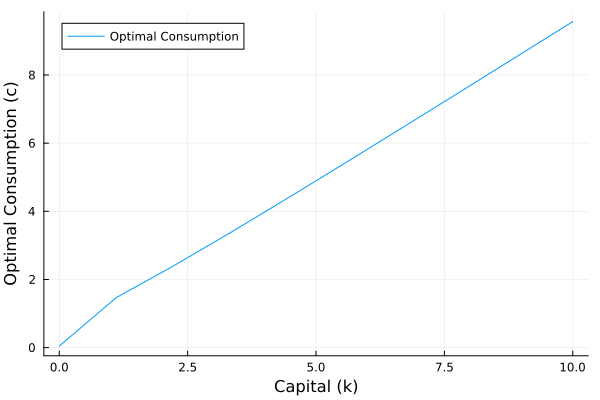

In [85]:
using Plots

function plot_policy_function(policy, kgrid)
    kp_opt = [p[1] for p in policy]
    l_opt = [p[2] for p in policy]
    c_opt = [p[3] for p in policy]

    p1 = plot(kgrid, kp_opt, xlabel="Capital (k)", ylabel="Optimal Capital (k')", label="Optimal Capital")
    p2 = plot(kgrid, l_opt, xlabel="Capital (k)", ylabel="Optimal Labor (l)", label="Optimal Labor")
    p3 = plot(kgrid, c_opt, xlabel="Capital (k)", ylabel="Optimal Consumption (c)", label="Optimal Consumption")
    
    display(p1)
    display(p2)
    display(p3)
end

plot_policy_function(policy, kgrid)

These results suggest there is something incorrect with our implementation of the maximisation problem. We believe it has to do with that we could not find a repareterisation of the equation that ran. This means our calculation for k' is incorrect meaning it also affects our v(k') which is worked out by interpolation but we could not work out how to do this. Therfore we believe a discussion about how many iterations it took to converge and runtime based on our code would be misleading. However we do believe that if implemented correctly it should drastically decrease the run time as it drastically decreases the amount of iterations the code is working out.

Part d

In [86]:
# Initialize parameters, grid, and initial guess for value function
p = (
    β = 0.95,    # Discount Rate
    δ = 0.05,    # Depreciation of capital
    σ = 2.0,     # Uncertainty aversion
    ν = 2.0,     # Risk aversion
    α = 1/3,     # Returns to scale
    A = 1.0,     # Productivity
    ϕ = 0.5      # Labor disutility parameter
)

n = 100
kgrid = range(0.1, 10, length=n)
V0 = zeros(n)

# Solve for the policy functions and value function
solution = solve_pfi!(p, kgrid, V0, policy_steps=200)

# Extract the solution components
V_steady_state = solution.V
policy_steady_state = solution.policy

# Check for convergence of value function
is_converged = all(V_steady_state .≈ V0)

# Check for convergence of policy function
is_policy_converged = policy_steady_state == solution.policy

if is_converged && is_policy_converged
    println("Steady state found!")
else
    println("Steady state not yet reached.")
end


ArgumentError: ArgumentError: invalid index: 0.3 of type Float64

In [21]:
function find_steady_state(p, kgrid, V0; tol = 1e-12, max_iter = 1000)
    V0      = copy(V0)
    V       = similar(V0)
    policy  = similar(V0, Int)
    errors  = Float64[]
    iter    = 0
    
    while true
        iter += 1
        update_bellman!(p, V, policy, kgrid, V0)
        ϵ = maximum(abs.(V - V0))
        push!(errors, ϵ)
        ϵ < tol && break
        iter > max_iter && break 
        V0 .= V
    end
    
    k_steady_state = kgrid[argmax(policy)]  # Capital level at the steady state
    return k_steady_state
end
# Initialize kgrid and V0
n = 100  # Number of grid points
kgrid = range(1e-4, length = n, stop = 100)  # Grid for capital
V0 = zeros(n)  # Initial guess for value function

# Compute the steady state
k_steady_state = find_steady_state(p, kgrid, V0)
println("Steady state level of capital: ", k_steady_state)

Steady state level of capital: 100.0


By keeping the same range, and increasing n, the function did not converge to the steady state level according to our code. So instead we then tested by increasing the range to see what happens then and if convergence ends up happening. Unfortunately given a mistake in the code for finding the steady state or previously meant that we could not find a steady state, as no matter what we tried the function determined a steady state has not been reached. This held even when we increased the tolerance of convergence.

Question 2
Part a

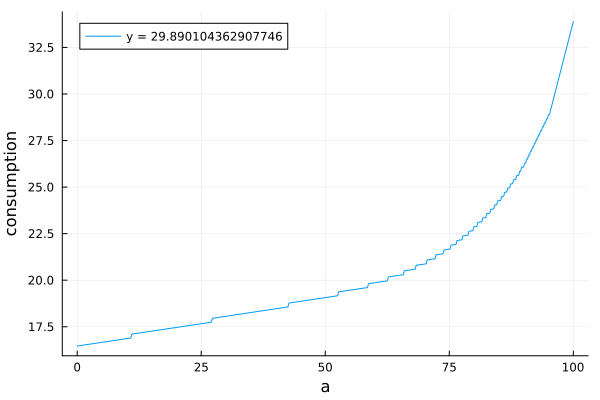

In [87]:
using QuantEcon

# Initializing parameters
beta = 0.95
r = 0.04
mu = 0.5
rho = 0.8
var = 0.1
sigma = 2

params = [beta, r, mu, rho, var, sigma]

function u(c, sigma)
    utility = similar(c)  # Create an array to store utilities
    for (i, val) in enumerate(c)
        if val <= 0
            utility[i] = -Inf
        else
            utility[i] = (val^(1-sigma))/(1-sigma)
        end
    end
    return utility
end


function update_bellman2(params, V, policy, optimal_consumption, agrid, ygrid, EV)
    beta, r, mu, rho, var, sigma = params
    for i in 1:length(agrid)
        a = agrid[i]
        for j in 1:length(ygrid)
            Y = exp(ygrid[j])

            z = (1+r)*a + Y
            c = z .- agrid  # Vectorized subtraction

            value = u(c, sigma) .+ beta * EV[:, j]

            V[i, j] = maximum(value)
            location = argmax(value)
            policy[i, j] = agrid[location]
            consumption = (1+r)*a + Y - agrid[location]
            optimal_consumption[i, j] = consumption
        end
    end
    return 
end

function solve_vfi2(params, agrid, V0, ny, tol = 1e-12, maxiter = 1000)
    V0 = copy(V0)
    beta, r, mu, rho, var, sigma = params
    V = copy(V0)
    errors = []
    iter = 0

    mc = rouwenhorst(ny, rho, var, mu)
    P = mc.p
    P = transpose(P)
    ygrid = mc.state_values

    V = zeros(length(agrid), length(ygrid))
    policy = zeros(Float64, length(agrid), length(ygrid)) # Change type to Float64
    optimal_consumption = zeros(length(agrid), length(ygrid))
    
    # Convert agrid to an array of Float64
    agrid_array = collect(agrid)
    
    while true
        iter += 1
        EV = V0 * P

        update_bellman2(params, V, policy, optimal_consumption, agrid_array, ygrid, EV)

        error = maximum(abs.(V .- V0))
        push!(errors, error)
        if error < tol || iter >= maxiter
            break
        end
        V0 .= V
    end
    
    return V, policy, optimal_consumption, iter, errors, agrid_array, ygrid
end


ny = 30
na = 500

agrid = range(1e-6, stop=100.0, length=na)  # Use range instead of LinRange
V0 = zeros(na, ny)
solution = solve_vfi2(params, agrid, V0, ny, 1e-3, 1000)

consumption = solution[3]
ygrid = solution[7]

using Plots

# Plotting the optimal consumption vs a for the highest possible starting value of y we have on our grid
plot(agrid, consumption[:,end], label = "y = $(exp(ygrid[end]))", xlabel = "a", ylabel = "consumption")


In [88]:
ny = 30
na = 500
agrid = range(1e-6, stop=500.0, length=na)  # Use range instead of LinRange
V0 = zeros(na, ny)
solution = solve_vfi2(params, agrid, V0, ny, 1e-3, 1000)

Aprime = solution[2]
consumption = solution[3]
ygrid = solution[6]
Y = [5, 10, 15, 20]

4-element Vector{Int64}:
  5
 10
 15
 20

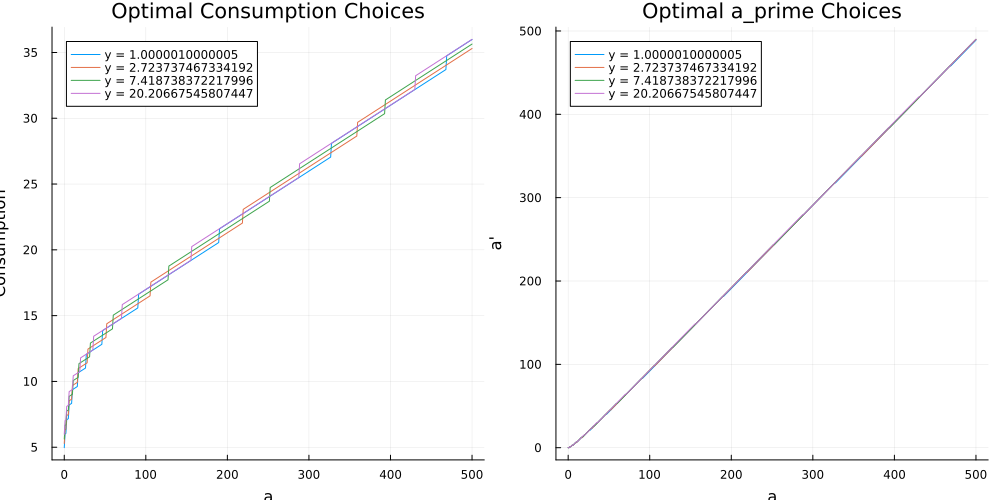

In [89]:
using Plots

# Create a plot for optimal consumption choices
plot1 = plot(size = (1000, 500), xlabel = "a", title = "Optimal Consumption Choices", ylabel = "Consumption")
for i in eachindex(Y)
    plot!(agrid, consumption[:, i], label = "y = $(exp(ygrid[i]))")
end

# Create a plot for optimal a_prime choices
plot2 = plot(size = (1000, 500), xlabel = "a", title = "Optimal a_prime Choices", ylabel = "a'")
for i in eachindex(Y)
    plot!(agrid, Aprime[:, i], label = "y = $(exp(ygrid[i]))")
end

plot(plot1, plot2, legend = true)

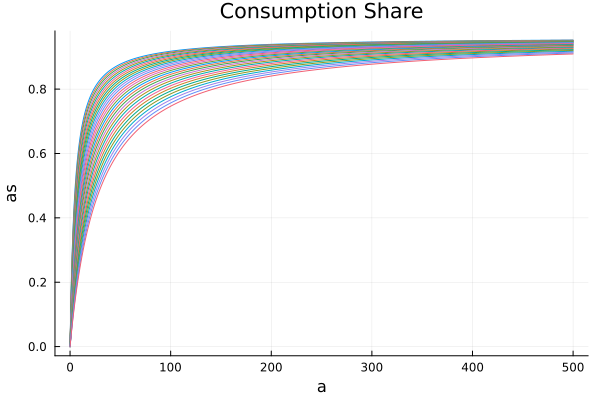

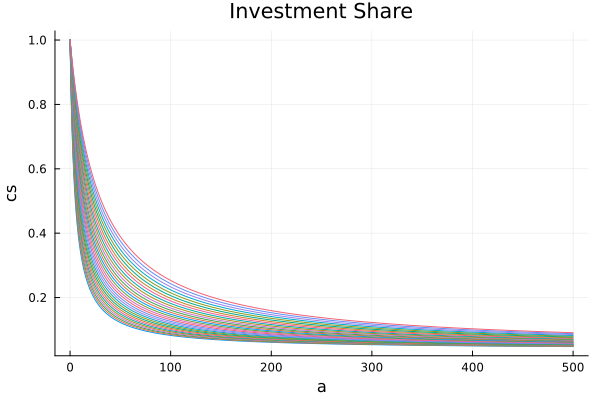

In [90]:
agrid, ygrid = solution[6], solution[7]
a′ = agrid[:]
z  = exp.(ygrid') .+ (1+r) .* agrid
c  = z .- a′

# Consumption/investment share 
cs = c ./ z
as = a′ ./ z

using Plots
plot()
display(plot!(agrid, as, xlabel="a", ylabel="as", title="Consumption Share", legend=false))
plot()
display(plot!(agrid, cs, xlabel="a", ylabel="cs", title="Investment Share", legend=false))

From the graph we can see that the investment share plus the consumption share add to 1. However there is a negative correlation between consumption share and a, and a positive correlation between investment share and a. We see that as assets (a) rise the consumption share significantly rises while the investment share significantly decreases. After assets greater than about 25 the consumption share is over 75%. What is interesting is that we see there are from everyone startng with 0 assets there are many different end points of the consumption and investment share that can be reached. Just looking at the comsumption share, the end points are between 0.75 and 0.85. Meaning that there must be differences to end up at different final positions. 

2 b

In [11]:
# # Extracting values from the solution tuple
# V, policy, optimal_consumption, iter, errors, agrid, ygrid = solution

# # Create empty arrays
# A_bin = Vector{Vector{Float64}}(undef, 0)
# C_bin = Vector{Vector{Float64}}(undef, 0)
# Y_bin = Vector{Vector{Float64}}(undef, 0)

# # Starting values
# a0p = 200
# y0 = 15

# # First position on the asset grid
# a_next = policy[a0p+1, y0+1]

# # For loop for 5 individuals
# for i in 1:5
#     a_bin = Float64[]
#     c_bin = Float64[]
#     y_bin = Float64[]
#     cons = (1+r)*agrid[a0p+1] + exp(ygrid[y0+1]) - agrid[round(Int, a_next)+1] # Consumption
#     # Loop over 100 periods
#     for j in 1:100
#         y_rand = rand(1:29) # Randomize income for each period
#         push!(y_bin, exp(ygrid[y_rand]))
#         a_previous = round(Int, a_next)
#         a_next = policy[a_previous+1, y_rand]
#         push!(a_bin, a_next)
#         consumption = (1+r)*agrid[a_previous+1] + exp(ygrid[y_rand]) - agrid[round(Int, a_next)+1] # Calculate consumption for each period
#         push!(c_bin, consumption)
#     end
#     push!(A_bin, a_bin)
#     push!(C_bin, c_bin)
#     push!(Y_bin, y_bin)
# end

In [91]:
V, policy, optimal_consumption, iter, errors, agrid, ygrid = solution

# Extracting values from the solution tuple
V, policy, optimal_consumption, iter, errors, agrid, ygrid = solution

# Create empty arrays
A_bin = []
C_bin = []
Y_bin = []

# Starting values
a0p = 200
y0 = 15

# First position on the asset grid
a_next = policy[a0p+1, y0+1]

# For loop for 5 individuals
for i in 1:5
    a_bin = []
    c_bin = []
    y_bin = []
    cons = (1+r)*agrid[a0p+1] + exp(ygrid[y0+1]) - agrid[round(Int, a_next)+1] # Consumption
    # Loop over 100 periods
    for j in 1:100
        y_rand = rand(1:29) # Randomize income for each period
        push!(y_bin, exp(ygrid[y_rand]))
        a_previous = round(Int, a_next)
        a_next = policy[round(Int, a_next)+1, y_rand]
        push!(a_bin, a_next)
        consumption = (1+r)*agrid[a_previous+1] + exp(ygrid[y_rand]) - agrid[round(Int, a_next)+1] # Calculate consumption for each period
        push!(c_bin, consumption)
    end
    push!(A_bin, a_bin)
    push!(C_bin, c_bin)
    push!(Y_bin, y_bin)
end



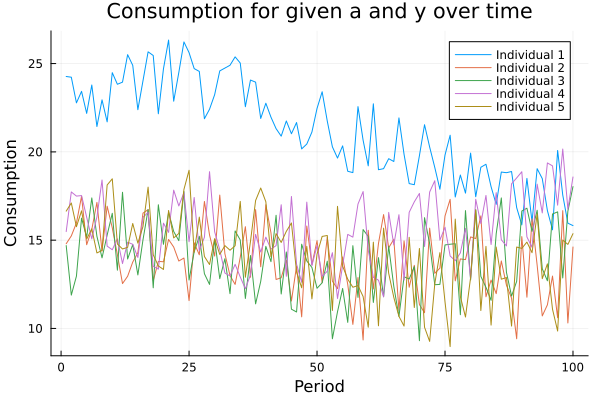

In [92]:
using Plots

# Plot Consumption
plot()
for i in 1:5
    plot!(1:100, C_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("Consumption")
title!("Consumption for given a and y over time")



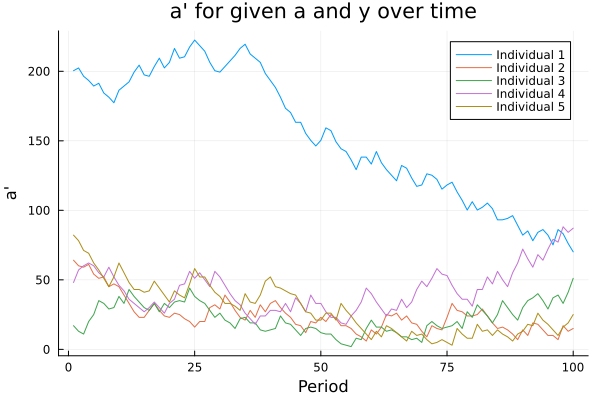

In [93]:
# Plot a'
plot()
for i in 1:5
    plot!(1:100, A_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("a'")
title!("a' for given a and y over time")


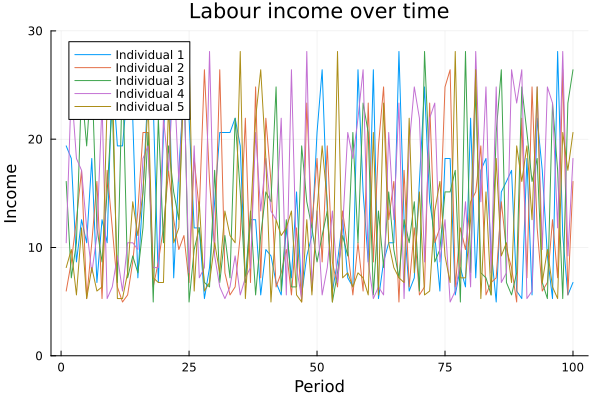

In [94]:
# Plot Income
plot()
for i in 1:5
    plot!(1:100, Y_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("Income")
title!("Labour income over time")
ylims!(0, 30)

part c

In [95]:
dist_bin_100 = []
for i in 1:10000
    for j in 1:100
        y_rand = rand(1:29)
        a_next = policy[round(Int, a_next)+1, y_rand]
        a = agrid[round(Int, a_next)+1]
        push!(dist_bin_100, a)

    end
end

dist_bin_200 = []
for i in 1:10000
    for j in 1:200
        y_rand = rand(1:29)
        a_next = policy[round(Int, a_next)+1, y_rand]
        a = agrid[round(Int, a_next)+1] 
        push!(dist_bin_200, a)

    end

end


dist_bin_300 = []
for i in 1:10000
    for i in 1:300
        y_rand = rand(1:29)
        a_next = policy[round(Int, a_next)+1, y_rand]
        a = agrid[round(Int, a_next)+1]
        push!(dist_bin_300, a)

    end
end

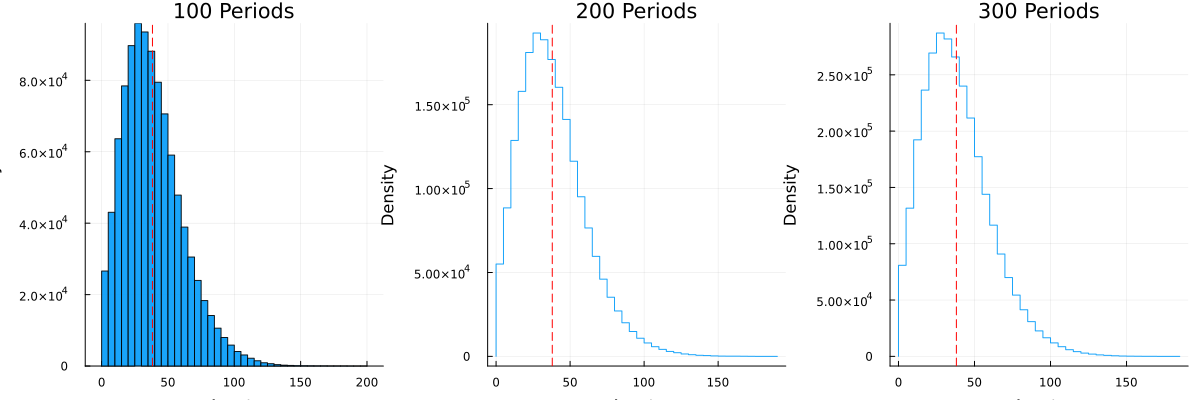

In [96]:
using Plots

# Initialize plots
plot1 = histogram(dist_bin_100, bins=50, normalize=false, alpha=0.9, xlabel="Assets", ylabel="Density", title="100 Periods")
vline!(plot1, [mean(dist_bin_100)], line=:dash, color=:red, label="Mean")

plot2 = histogram(dist_bin_200, bins=50, normalize=false, alpha=0.9, xlabel="Assets", ylabel="Density", title="200 Periods")
vline!(plot2, [mean(dist_bin_200)], line=:dash, color=:red, label="Mean")

plot3 = histogram(dist_bin_300, bins=50, normalize=false, alpha=0.9, xlabel="Assets", ylabel="Density", title="300 Periods")
vline!(plot3, [mean(dist_bin_300)], line=:dash, color=:red, label="Mean")

# Combine plots
plt = plot(plot1, plot2, plot3, size=(1200, 400), layout = (1,3), legend=false)
display(plt)

These graphs show asset distribution in final period for 100, 200 and 300 periods. After what was discussed in the tutorial we see that we have an ergodic distribution, which means if they ever converge they are not estimating the whole distribution.

Part d

In [50]:
# function update_bellman3(params, V, policy, optimal_consumption, agrid, ygrid, EV, tax = 0.25)
#     beta, r, mu, rho, var, sigma = params
#     for i in 1:length(agrid)
#         a = agrid[i]
#         for j in 1:length(ygrid)
#             Y = exp(ygrid[j])

#             z = (((1-tax)*r)*a + (1-tax)*(Y))            
#             c = z .- agrid  # Vectorized subtraction

#             value = u(c, sigma) .+ beta * EV[:, j]

#             V[i, j] = maximum(value)
#             location = argmax(value)
#             policy[i, j] = agrid[location]
#             consumption = (1+r)*a + Y - agrid[location]
#             optimal_consumption[i, j] = consumption
#         end
#     end
#     return 
# end

# function solve_vfi3(params, agrid, V0, ny, tol = 1e-12, maxiter = 1000)
#     V0 = copy(V0)
#     beta, r, mu, rho, var, sigma = params
#     V = copy(V0)
#     errors = []
#     iter = 0

#     mc = rouwenhorst(ny, rho, var, mu)
#     P = mc.p
#     P = transpose(P)
#     ygrid = mc.state_values

#     V = zeros(length(agrid), length(ygrid))
#     policy = zeros(Float64, length(agrid), length(ygrid)) # Change type to Float64
#     optimal_consumption = zeros(length(agrid), length(ygrid))
    
#     # Convert agrid to an array of Float64
#     agrid_array = collect(agrid)
    
#     while true
#         iter += 1
#         EV = V0 * P

#         update_bellman3(params, V, policy, optimal_consumption, agrid_array, ygrid, EV)

#         error = maximum(abs.(V .- V0))
#         push!(errors, error)
#         if error < tol || iter >= maxiter
#             break
#         end
#         V0 .= V
#     end
    
#     return V, policy, optimal_consumption, iter, errors, agrid_array, ygrid
# end



solve_vfi3 (generic function with 3 methods)

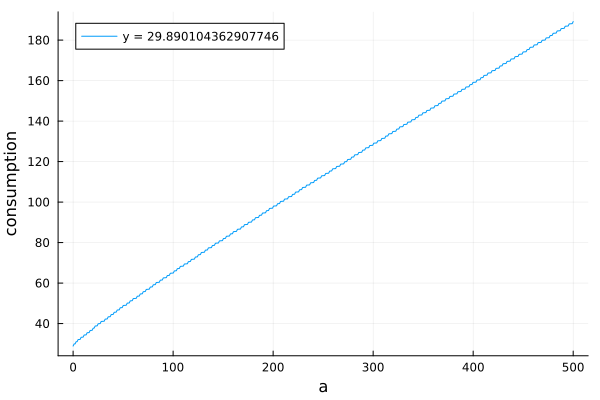

In [110]:

function update_bellman2(params, V, policy, optimal_consumption, agrid, ygrid, EV)
    tax = 0.25
    beta, r, mu, rho, var, sigma = params
    for i in 1:length(agrid)
        a = agrid[i]
        for j in 1:length(ygrid)
            Y = exp(ygrid[j])

            z = (1-tax)*((1+r)*a + Y)
            c = z .- agrid  # Vectorized subtraction

            value = u(c, sigma) .+ beta * EV[:, j]

            V[i, j] = maximum(value)
            location = argmax(value)
            policy[i, j] = agrid[location]
            consumption = (1+r)*a + Y - agrid[location]
            optimal_consumption[i, j] = consumption
        end
    end
    return 
end

function solve_vfi2(params, agrid, V0, ny, tol = 1e-12, maxiter = 1000)
    V0 = copy(V0)
    beta, r, mu, rho, var, sigma = params
    V = copy(V0)
    errors = []
    iter = 0

    mc = rouwenhorst(ny, rho, var, mu)
    P = mc.p
    P = transpose(P)
    ygrid = mc.state_values

    V = zeros(length(agrid), length(ygrid))
    policy = zeros(Float64, length(agrid), length(ygrid)) # Change type to Float64
    optimal_consumption = zeros(length(agrid), length(ygrid))
    
    # Convert agrid to an array of Float64
    agrid_array = collect(agrid)
    
    while true
        iter += 1
        EV = V0 * P

        update_bellman2(params, V, policy, optimal_consumption, agrid_array, ygrid, EV)

        error = maximum(abs.(V .- V0))
        push!(errors, error)
        if error < tol || iter >= maxiter
            break
        end
        V0 .= V
    end
    
    return V, policy, optimal_consumption, iter, errors, agrid_array, ygrid
end


ny = 30
na = 500

agrid = range(1e-6, stop=500.0, length=na)  # Use range instead of LinRange
V0 = zeros(na, ny)
solution = solve_vfi2(params, agrid, V0, ny, 1e-3, 1000)

consumption = solution[3]
ygrid = solution[7]

using Plots

# Plotting the optimal consumption vs a for the highest possible starting value of y we have on our grid
plot(agrid, consumption[:,end], label = "y = $(exp(ygrid[end]))", xlabel = "a", ylabel = "consumption")

In [111]:
# Extracting values from the solution tuple
V, policy, optimal_consumption, iter, errors, agrid, ygrid = solution

# Create empty arrays
A_bin = Vector{Vector{Float64}}(undef, 0)
C_bin = Vector{Vector{Float64}}(undef, 0)
Y_bin = Vector{Vector{Float64}}(undef, 0)

# Starting values
a0p = 200
y0 = 15

# First position on the asset grid
a_next = policy[a0p+1, y0+1]

# For loop for 5 individuals
for i in 1:5
    a_bin = Float64[]
    c_bin = Float64[]
    y_bin = Float64[]
    cons = (1+r)*agrid[a0p+1] + exp(ygrid[y0+1]) - agrid[round(Int, a_next)+1] # Consumption
    # Loop over 100 periods
    for j in 1:100
        y_rand = rand(1:29) # Randomize income for each period
        push!(y_bin, exp(ygrid[y_rand]))
        a_previous = round(Int, a_next)
        a_next = policy[a_previous+1, y_rand]
        push!(a_bin, a_next)
        consumption = (1+r)*agrid[a_previous+1] + exp(ygrid[y_rand]) - agrid[round(Int, a_next)+1] # Calculate consumption for each period
        push!(c_bin, consumption)
    end
    push!(A_bin, a_bin)
    push!(C_bin, c_bin)
    push!(Y_bin, y_bin)
end


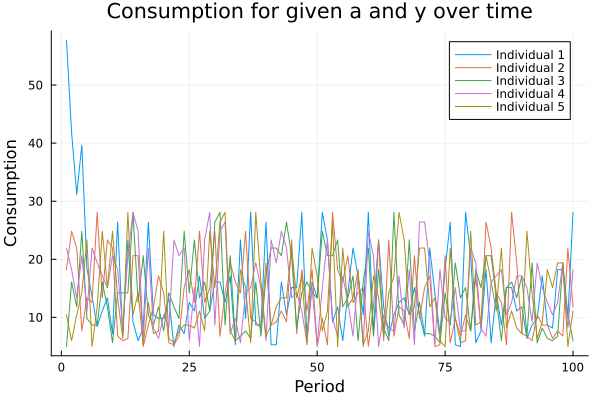

In [112]:
using Plots

# Plot Consumption
plot()
for i in 1:5
    plot!(1:100, C_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("Consumption")
title!("Consumption for given a and y over time")

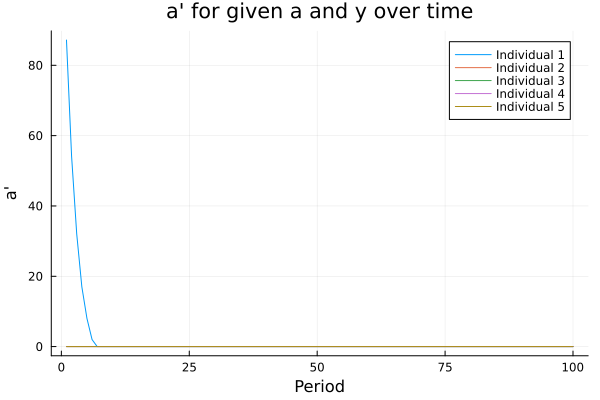

In [106]:
# Plot a'
plot()
for i in 1:5
    plot!(1:100, A_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("a'")
title!("a' for given a and y over time")


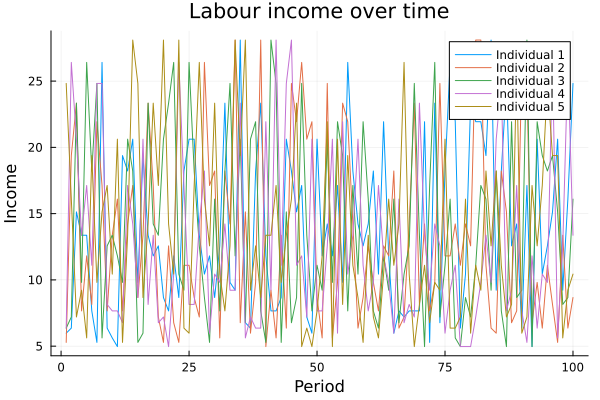

In [107]:

# Plot Income
plot()
for i in 1:5
    plot!(1:100, Y_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("Income")
title!("Labour income over time")

In [108]:
V, policy, optimal_consumption, iter, errors, agrid, ygrid = solution


dist_bin_100 = []
for i in 1:10000
    for j in 1:100
        y_rand = rand(1:29)
        a_next = policy[round(Int, a_next)+1, y_rand]
        a = agrid[round(Int, a_next)+1]
        push!(dist_bin_100, a)

    end
end

dist_bin_200 = []
for i in 1:10000
    for j in 1:200
        y_rand = rand(1:29)
        a_next = policy[round(Int, a_next)+1, y_rand]
        a = agrid[round(Int, a_next)+1] 
        push!(dist_bin_200, a)

    end

end


dist_bin_300 = []
for i in 1:10000
    for j in 1:300
        y_rand = rand(1:29)
        a_next = policy[round(Int, a_next)+1, y_rand]
        a = agrid[round(Int, a_next)+1]
        push!(dist_bin_300, a)

    end
end

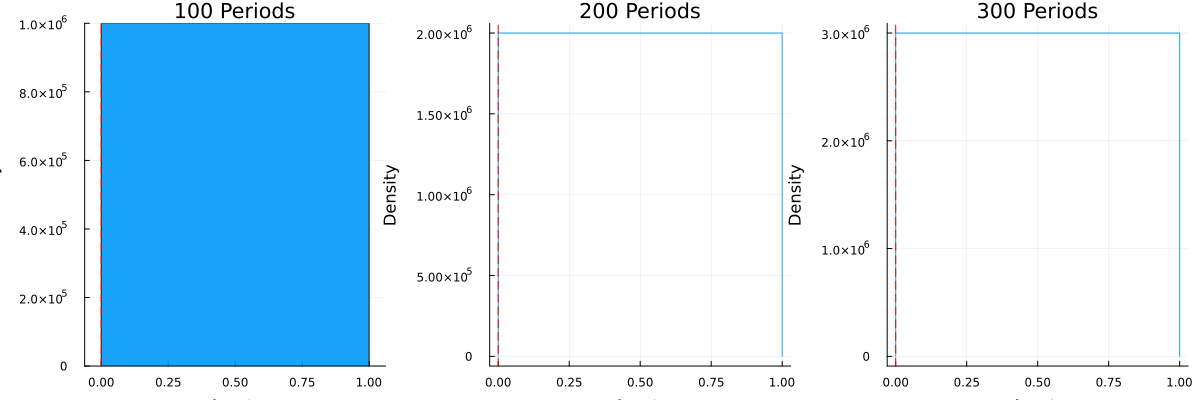

In [109]:
using Plots

# Initialize plots
plot1 = histogram(dist_bin_100, bins=25, normalize=false, alpha=0.9, xlabel="Assets", ylabel="Density", title="100 Periods")
vline!(plot1, [mean(dist_bin_100)], line=:dash, color=:red, label="Mean")

plot2 = histogram(dist_bin_200, bins=25, normalize=false, alpha=0.9, xlabel="Assets", ylabel="Density", title="200 Periods")
vline!(plot2, [mean(dist_bin_200)], line=:dash, color=:red, label="Mean")

plot3 = histogram(dist_bin_300, bins=25, normalize=false, alpha=0.9, xlabel="Assets", ylabel="Density", title="300 Periods")
vline!(plot3, [mean(dist_bin_300)], line=:dash, color=:red, label="Mean")

# Combine plots
plt = plot(plot1, plot2, plot3, size=(1200, 400), layout = (1,3), legend=false)
display(plt)

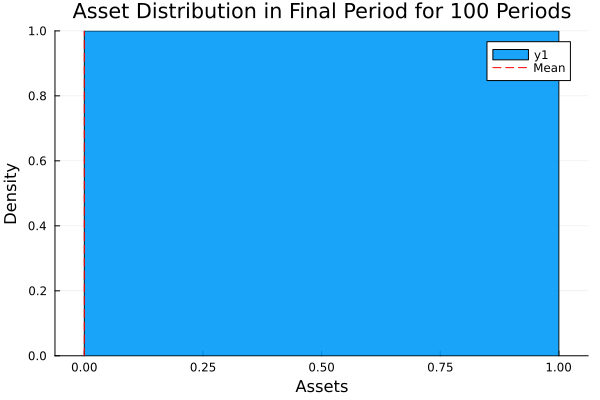

In [72]:

# Plot histogram
histogram(dist_bin_100, bins=25, normalize=true, alpha=0.9, xlabel="Assets", ylabel="Density", title="Asset Distribution in Final Period for 100 Periods")

# Add dashed line for mean
vline!([mean(dist_bin_100)], line=:dash, color=:red, label="Mean")

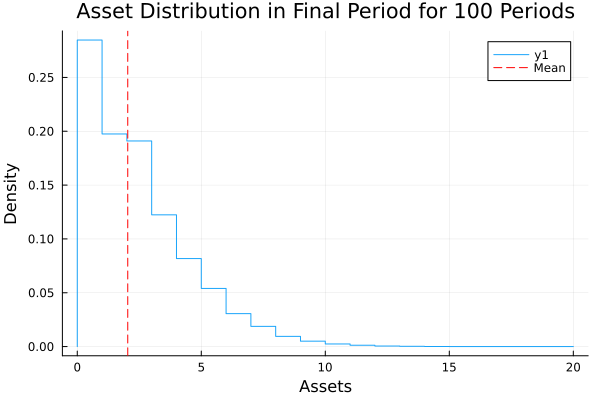

In [28]:
# Plot histogram
histogram(dist_bin_200, bins=25, normalize=true, alpha=0.9, xlabel="Assets", ylabel="Density", title="Asset Distribution in Final Period for 100 Periods")

# Add dashed line for mean
vline!([mean(dist_bin_200)], line=:dash, color=:red, label="Mean")

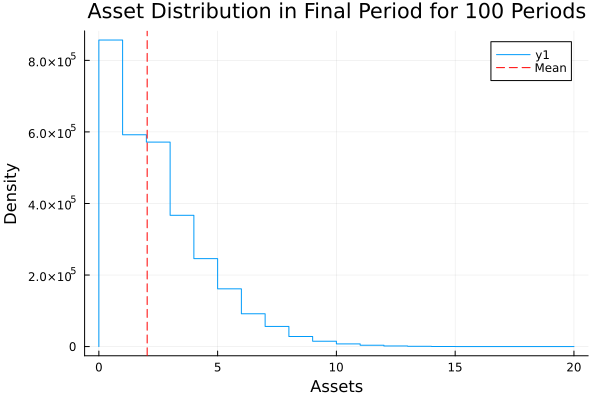

In [29]:
# Plot histogram
histogram(dist_bin_300, bins=25, xlabel="Assets", ylabel="Density", title="Asset Distribution in Final Period for 100 Periods")

# Add dashed line for mean
vline!([mean(dist_bin_300)], line=:dash, color=:red, label="Mean")